In [1]:
# ! pip install pandas numpy seaborn matplotlib scikit-learn pyod

## Import Libraries

In [2]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from pyod.models.knn import KNN
from scipy.stats import boxcox


## Load data

In [3]:
df = pd.read_csv('churn_data.csv')
df

,customerID,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,Mailed check,56.95,1889.50,No
2,3668-QPYBK,2,Yes,Month-to-month,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,24,Yes,One year,Mailed check,84.80,1990.50,No
7039,2234-XADUH,72,Yes,One year,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,11,No,Month-to-month,Electronic check,29.60,346.45,No
7041,8361-LTMKD,4,Yes,Month-to-month,Mailed check,74.40,306.60,Yes


## Data Filtering

In [34]:
df['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [4]:
# Filter the churn dataset for customers with total charges greater than or equal 3000
high_totalcharges_df = df[df['TotalCharges'] >= 3000]
high_totalcharges_df.head()

,customerID,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
8,7892-POOKP,28,Yes,Month-to-month,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,62,Yes,One year,Bank transfer (automatic),56.15,3487.95,No
12,8091-TTVAX,58,Yes,One year,Credit card (automatic),100.35,5681.10,No
13,0280-XJGEX,49,Yes,Month-to-month,Bank transfer (automatic),103.70,5036.30,Yes
15,3655-SNQYZ,69,Yes,Two year,Credit card (automatic),113.25,7895.15,No


In [5]:
contract_df = df[df['Contract'] == 'Contract']
contract_df['Churn'].unique()

array([], dtype=object)

## Checking for outliers

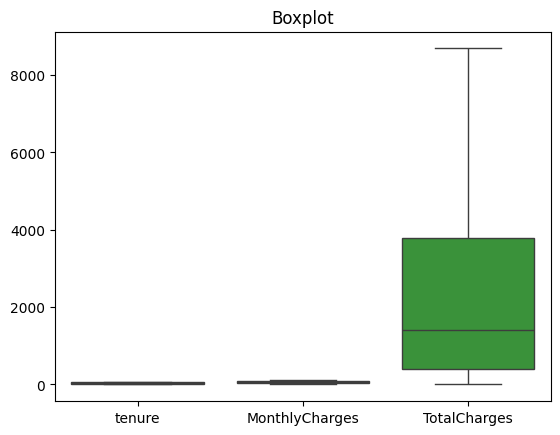

In [6]:
columns = df.select_dtypes(include=np.number).columns
sns.boxplot(data=df[columns])
plt.title("Boxplot")
plt.show()

## Clipping outliers

In [7]:
for column in columns:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    upper_boundary = q3 + 1.5 * iqr
    lower_boundary = q1 - 1.5 * iqr
    
    # Replace values beyond the upper and lower boundaries with the boundaries
    df[column] = df[column].apply(lambda x: upper_boundary if x > upper_boundary else (lower_boundary if x < lower_boundary else x))


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customerID      7043 non-null   object 
 1   tenure          7043 non-null   int64  
 2   PhoneService    7043 non-null   object 
 3   Contract        7043 non-null   object 
 4   PaymentMethod   7043 non-null   object 
 5   MonthlyCharges  7043 non-null   float64
 6   TotalCharges    7032 non-null   float64
 7   Churn           7043 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 440.3+ KB


## Check missing values

In [9]:
df.isna().sum()

customerID         0
tenure             0
PhoneService       0
Contract           0
PaymentMethod      0
MonthlyCharges     0
TotalCharges      11
Churn              0
dtype: int64

## Fill rows with missing values

In [10]:
columns_to_fill = columns
df[columns_to_fill] = df[columns_to_fill].fillna(df[columns_to_fill].mean())

In [11]:
df.isna().sum()

customerID        0
tenure            0
PhoneService      0
Contract          0
PaymentMethod     0
MonthlyCharges    0
TotalCharges      0
Churn             0
dtype: int64

## Converting categorical columns to numeric

In [12]:
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
df['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [13]:
df['PhoneService'] = df['PhoneService'].replace({'No': 0, 'Yes': 1})
df['PhoneService'].value_counts()

PhoneService
1    6361
0     682
Name: count, dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customerID      7043 non-null   object 
 1   tenure          7043 non-null   int64  
 2   PhoneService    7043 non-null   int64  
 3   Contract        7043 non-null   object 
 4   PaymentMethod   7043 non-null   object 
 5   MonthlyCharges  7043 non-null   float64
 6   TotalCharges    7043 non-null   float64
 7   Churn           7043 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 440.3+ KB


## Feature Engineering

In [15]:
df_copy = df.copy()
df_copy

,customerID,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,0,Month-to-month,Electronic check,29.85,29.85,0
1,5575-GNVDE,34,1,One year,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2,1,Month-to-month,Mailed check,53.85,108.15,1
3,7795-CFOCW,45,0,One year,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2,1,Month-to-month,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,24,1,One year,Mailed check,84.80,1990.50,0
7039,2234-XADUH,72,1,One year,Credit card (automatic),103.20,7362.90,0
7040,4801-JZAZL,11,0,Month-to-month,Electronic check,29.60,346.45,0
7041,8361-LTMKD,4,1,Month-to-month,Mailed check,74.40,306.60,1


In [16]:

scaler = MinMaxScaler()

# Reshape the data 
total_charges_reshaped = df_copy['TotalCharges'].values.reshape(-1, 1)

# Fit and transform the data
df_copy['TotalCharges'] = scaler.fit_transform(total_charges_reshaped)

In [17]:
scaler = StandardScaler()

# Reshape the data 
monthly_charges_reshaped = df_copy['MonthlyCharges'].values.reshape(-1, 1)

# Fit and transform the data
df_copy['MonthlyCharges'] = scaler.fit_transform(monthly_charges_reshaped)

In [18]:
df_copy

,customerID,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,0,Month-to-month,Electronic check,-1.160323,0.001275,0
1,5575-GNVDE,34,1,One year,Mailed check,-0.259629,0.215867,0
2,3668-QPYBK,2,1,Month-to-month,Mailed check,-0.362660,0.010310,1
3,7795-CFOCW,45,0,One year,Bank transfer (automatic),-0.746535,0.210241,0
4,9237-HQITU,2,1,Month-to-month,Electronic check,0.197365,0.015330,1
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,24,1,One year,Mailed check,0.665992,0.227521,0
7039,2234-XADUH,72,1,One year,Credit card (automatic),1.277533,0.847461,0
7040,4801-JZAZL,11,0,Month-to-month,Electronic check,-1.168632,0.037809,0
7041,8361-LTMKD,4,1,Month-to-month,Mailed check,0.320338,0.033210,1


## Histograms to visualize effect of scaling

<Axes: title={'center': 'Scaled TotalCharges'}, ylabel='Frequency'>

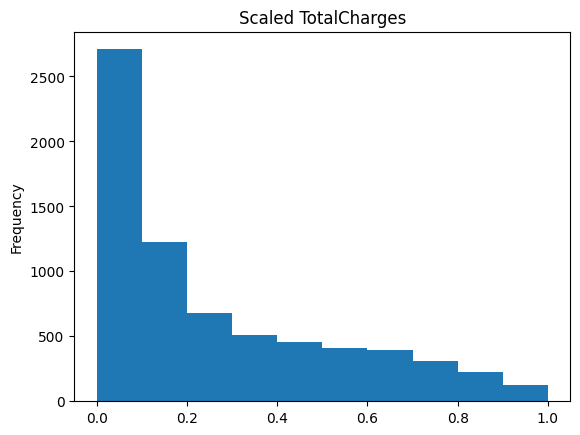

In [19]:
df_copy['TotalCharges'].plot.hist(title='Scaled TotalCharges')

<Axes: title={'center': 'Scaled MonthlyCharges'}, ylabel='Frequency'>

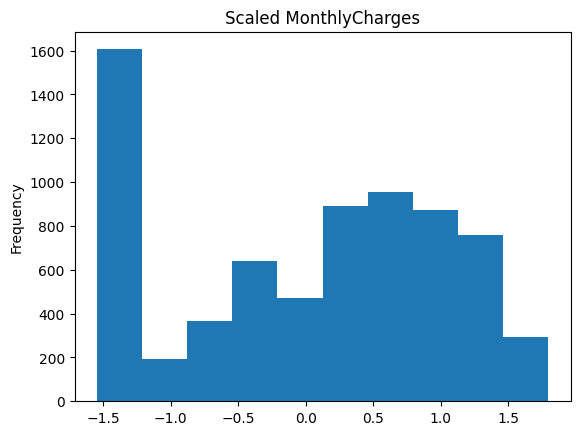

In [20]:
df_copy['MonthlyCharges'].plot.hist(title='Scaled MonthlyCharges')

<Axes: title={'center': 'Original TotalCharges'}, ylabel='Frequency'>

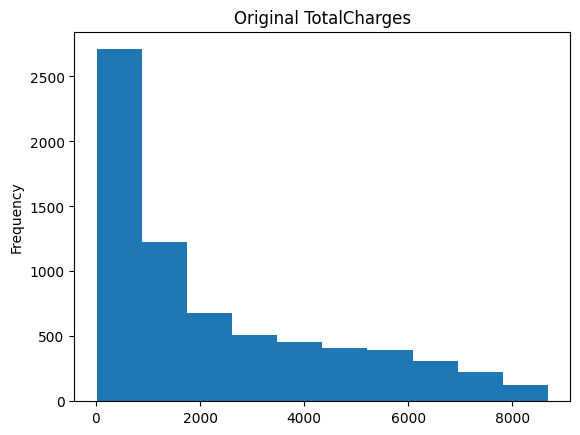

In [21]:
df['TotalCharges'].plot.hist(title='Original TotalCharges')

<Axes: title={'center': 'Original MonthlyCharges'}, ylabel='Frequency'>

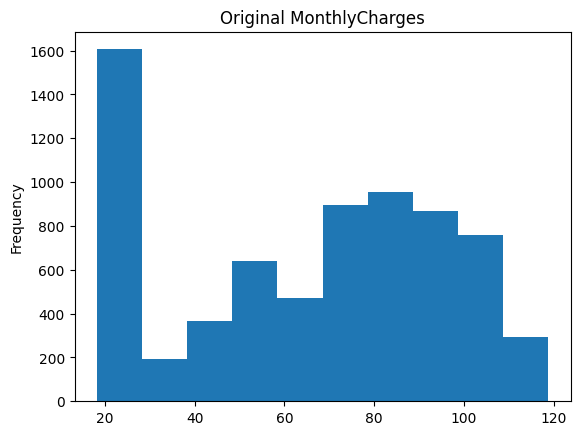

In [22]:
df['MonthlyCharges'].plot.hist(title='Original MonthlyCharges')

## Combine columns to create additional features

In [23]:

df_copy['Scaled_TotalCharges_to_MonthlyCharges_ratio'] = df_copy['TotalCharges'] / df_copy['MonthlyCharges']

df_copy


,customerID,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Scaled_TotalCharges_to_MonthlyCharges_ratio
0,7590-VHVEG,1,0,Month-to-month,Electronic check,-1.160323,0.001275,0,-0.001099
1,5575-GNVDE,34,1,One year,Mailed check,-0.259629,0.215867,0,-0.831443
2,3668-QPYBK,2,1,Month-to-month,Mailed check,-0.362660,0.010310,1,-0.028430
3,7795-CFOCW,45,0,One year,Bank transfer (automatic),-0.746535,0.210241,0,-0.281622
4,9237-HQITU,2,1,Month-to-month,Electronic check,0.197365,0.015330,1,0.077673
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,24,1,One year,Mailed check,0.665992,0.227521,0,0.341628
7039,2234-XADUH,72,1,One year,Credit card (automatic),1.277533,0.847461,0,0.663358
7040,4801-JZAZL,11,0,Month-to-month,Electronic check,-1.168632,0.037809,0,-0.032353
7041,8361-LTMKD,4,1,Month-to-month,Mailed check,0.320338,0.033210,1,0.103672


## Plot histogram for the new feature

<Axes: title={'center': 'Scaled TotalCharges/MonthlyCharges Ratio'}, ylabel='Frequency'>

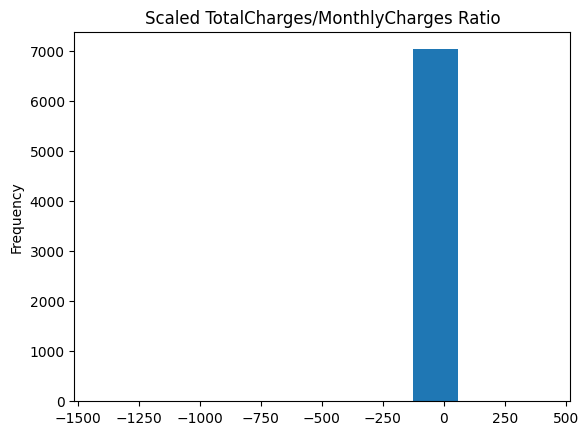

In [24]:
df_copy['Scaled_TotalCharges_to_MonthlyCharges_ratio'].plot.hist(title='Scaled TotalCharges/MonthlyCharges Ratio')

In [25]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   customerID                                   7043 non-null   object 
 1   tenure                                       7043 non-null   int64  
 2   PhoneService                                 7043 non-null   int64  
 3   Contract                                     7043 non-null   object 
 4   PaymentMethod                                7043 non-null   object 
 5   MonthlyCharges                               7043 non-null   float64
 6   TotalCharges                                 7043 non-null   float64
 7   Churn                                        7043 non-null   int64  
 8   Scaled_TotalCharges_to_MonthlyCharges_ratio  7043 non-null   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 495.3+ KB


In [26]:
df_copy['customerID'] = range(1, len(df_copy) + 1)

## Save prepared data

In [27]:
df_copy.to_csv('prepared_churn_data.csv', index=False)

## Advanced Outlier detection

<Axes: >

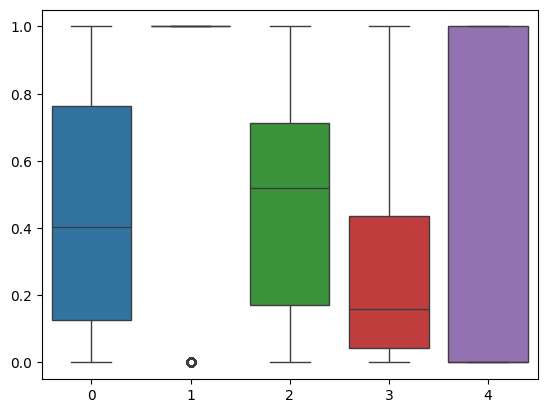

In [28]:
numeric_df = df.select_dtypes(exclude=['object'])

scaler = MinMaxScaler()
scaled_numeric = scaler.fit_transform(numeric_df)

sns.boxplot(data = scaled_numeric)

In [29]:
od = KNN(contamination=0.05)
od.fit(scaled_numeric)

outliers = od.predict(scaled_numeric)
outliers

outliers.sum()

df[outliers.astype('bool')]

,customerID,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
107,9750-BOOHV,32,0,One year,Mailed check,30.15,927.65,0
114,5256-SKJGO,64,0,Two year,Electronic check,54.60,3423.50,0
116,9560-BBZXK,36,0,Two year,Bank transfer (automatic),31.05,1126.35,0
131,6207-WIOLX,25,0,Month-to-month,Credit card (automatic),58.60,1502.65,1
132,8587-XYZSF,67,1,Two year,Bank transfer (automatic),50.55,3260.10,0
...,...,...,...,...,...,...,...,...
6972,6664-FPDAC,56,1,One year,Electronic check,111.95,6418.90,1
6980,0786-VSSUD,16,0,Month-to-month,Mailed check,39.00,679.85,1
6984,6447-GORXK,31,0,Month-to-month,Credit card (automatic),25.00,789.20,0
6996,4174-LPGTI,41,1,One year,Bank transfer (automatic),66.50,2728.60,1


## Converting categorical variables to numeric

In [30]:
pd.get_dummies(df['Contract'])

,Month-to-month,One year,Two year
0,True,False,False
1,False,True,False
2,True,False,False
3,False,True,False
4,True,False,False
...,...,...,...
7038,False,True,False
7039,False,True,False
7040,True,False,False
7041,True,False,False


In [31]:
one_hot_df = pd.concat([df.drop('Contract', axis=1), pd.get_dummies(df['Contract'], drop_first=True)],axis=1)
one_hot_df

,customerID,tenure,PhoneService,PaymentMethod,MonthlyCharges,TotalCharges,Churn,One year,Two year
0,7590-VHVEG,1,0,Electronic check,29.85,29.85,0,False,False
1,5575-GNVDE,34,1,Mailed check,56.95,1889.50,0,True,False
2,3668-QPYBK,2,1,Mailed check,53.85,108.15,1,False,False
3,7795-CFOCW,45,0,Bank transfer (automatic),42.30,1840.75,0,True,False
4,9237-HQITU,2,1,Electronic check,70.70,151.65,1,False,False
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,24,1,Mailed check,84.80,1990.50,0,True,False
7039,2234-XADUH,72,1,Credit card (automatic),103.20,7362.90,0,True,False
7040,4801-JZAZL,11,0,Electronic check,29.60,346.45,0,False,False
7041,8361-LTMKD,4,1,Mailed check,74.40,306.60,1,False,False


## Box-Cox transformation to tenure

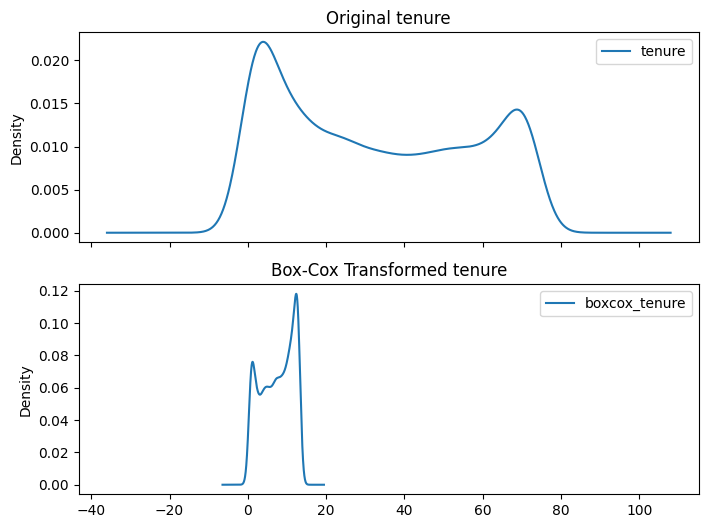

In [33]:

df['boxcox_tenure'], _ = boxcox(df['tenure'] + 1) 

# Plot the density of the original and transformed columns
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)
df[['tenure']].plot.density(ax=axes[0], title='Original tenure')
df[['boxcox_tenure']].plot.density(ax=axes[1], title='Box-Cox Transformed tenure')

plt.show()

# Analysis and Interpretation

## Customer churn distribution

The analysis begins by examining the distribution of customers based on their churn status. It reveals that out of the total customers, 5174 did not churn, while 1869 customers churned. Understanding this distribution is fundamental for further exploration into customer retention strategies and predictive modeling.

## Filtering data

Data is filtered based on the TotalCharges column, creating a dataframe high_totalcharges_df that contains customers with total charges greater  than or equal to 3000


## Visualizing Numeric Data Distribution:

Using a boxplot, we visually explore the distribution of key numeric columns such as tenure, MonthlyCharges, and TotalCharges. This visualization technique assists in identifying any potential outliers and gaining insights into the spread of data, essential for assessing data quality and detecting anomalies.


## Managing Outliers

To enhance the reliability of our dataset, we employ the interquartile range (IQR) method to address outliers in each numeric column. Outliers, which can skew statistical analyses, are clipped to ensure the robustness of subsequent data analysis processes.

## Addressing Missing Values

Upon inspection, 11 missing values are identified in the TotalCharges column. To maintain data integrity, these missing values are filled with mean using the fillna() function, ensuring our analysis is based on complete data.


## Preparing for Machine Learning

Categorical variables such as Churn and PhoneService are converted into numeric format to facilitate model training and analysis. This conversion is necessary for compatibility with machine learning algorithms, enabling quantitative analysis and ensuring seamless model training.


##  Enhancing Predictive Features

Feature engineering techniques, including Sxaling using MinMaxScaler and StandardScaler and the creation of the new feature, are employed to enrich the dataset.The newly introduced ratio provides valuable insights into variable relationships. These engineered features aim to enhance the predictive power of the model.

## Advanced Outlier Detection - Boxplot Analysis

Advanced outlier detection using boxplot analysis is performed to understand the distribution of standardized values across different features.

```shell 

Tenure - Most customers have similar tenure values, with a few extreme cases at both ends of the distribution.

PhoneService - Being a binary variable, the values are concentrated at the extremes without any outliers.

Churn -  Similarly, a binary variable with values concentrated at the extremes without outliers.

Scaled_MonthlyCharges_to_TotalCharges_Ratio -  This ratio shows variations in spending patterns, with some customers having significantly different ratios.
```

## Box-Cox Transformation and Density Plot Comparison

The Box-Cox transformation is applied to the tenure column of the DataFrame df to address skewness and stabilize variance. The transformation is implemented using the boxcox function, and the resulting transformed values are stored in a new column named boxcox_tenure. Additionally, a constant value of 1 is added to the tenure column before transformation to handle zero values.

To visually assess the impact of the transformation, density plots of both the original tenure column and the transformed boxcox_tenure column are generated. These plots illustrate the distributional differences between the original and transformed data. The density plot of the original tenure column provides insights into its initial distribution, while the density plot of the transformed boxcox_tenure column demonstrates the effects of the Box-Cox transformation on normalizing the data distribution.
